<a href="https://colab.research.google.com/github/pxpc2/qualvinho/blob/main/decisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
!pip install -q dtreeviz
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
wines = pd.read_csv('/content/gdrive/MyDrive/XWines_Slim/XWines_Slim_1K_wines.csv',
                    usecols=['WineID', 'WineName', 'Type', 'Grapes',
                             'Body', 'Harmonize', 'Acidity', 'ABV', 'Code', 'Country', 'Elaborate', 'WineryName'],
                     delimiter=',', header=None, skiprows=1, low_memory=False,
                    names=['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes',
                           'Harmonize', 'ABV', 'Body', 'Acidity', 'Code',
                           'Country', 'RegionID', 'RegionName', 'WineryID',
                           'WineryName','Website', 'Vintages'],
                    dtype={'WineID': int, 'WineName': str, 'Type': str,
                           'Grapes': str, 'Harmonize': str, 'Body': str,
                           'Acidity': str, 'ABV': str,
                           'Code': str, 'Elaborate': str, 'Country': str, 'WineryName': str})



ratings = pd.read_csv('/content/gdrive/MyDrive/XWines_Slim/XWines_Slim_150K_ratings.csv',
                      usecols=['UserID', 'WineID', 'Rating'],
                      delimiter=',', header=None, skiprows=1, low_memory=False,
                      names=['RatingID', 'UserID', 'WineID', 'Vintage', 'Rating', 'Date'],
                      dtype={'UserID': int, 'WineID': int, 'Rating': float})

In [3]:
df = ratings.merge(wines)
df.columns

Index(['UserID', 'WineID', 'Rating', 'WineName', 'Type', 'Elaborate', 'Grapes',
       'Harmonize', 'ABV', 'Body', 'Acidity', 'Code', 'Country', 'WineryName'],
      dtype='object')

In [4]:
df['Acidity'].unique()

array(['High', 'Medium', 'Low'], dtype=object)

In [5]:
df['Rating'].unique()

array([4.5, 4. , 3.5, 5. , 3. , 1. , 2. , 2.5, 1.5])

In [6]:
bodies = 'Very full-bodied', 'Full-bodied', 'Medium-bodied', 'Light-bodied', 'Very light-bodied'
df['Body'] = df['Body'].astype('category')
df['Body'].cat.set_categories(bodies, ordered=True, inplace=True)

<ipython-input-6-29c373dca47b>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Body'].cat.set_categories(bodies, ordered=True, inplace=True)


In [7]:
acidities = 'High', 'Medium', 'Low'
df['Acidity'] = df['Acidity'].astype('category')
df['Acidity'].cat.set_categories(acidities, ordered=True, inplace=True)

<ipython-input-7-054233d5dd41>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Acidity'].cat.set_categories(acidities, ordered=True, inplace=True)


In [8]:
dep_var = 'Rating'
df[dep_var] = np.log(df[dep_var])

In [9]:
procs = [Categorify, FillMissing]

In [10]:
splits = RandomSplitter(seed=42)(df)

In [11]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [12]:
len(to.train),len(to.valid)

(120000, 30000)

In [13]:
to.show(3)

,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,WineryName,UserID,WineID,Rating
137355,Unwooded Pinot Noir,Red,Varietal/100%,['Pinot Noir'],"['Beef', 'Veal', 'Game Meat', 'Poultry']",12.5,Medium-bodied,High,ZA,South Africa,Haute Cabrière,1149843,171438,3.5
35229,Hemisferio Reserva Carmenère,Red,Varietal/100%,['Carmenère'],"['Beef', 'Pasta', 'Lamb', 'Poultry']",13.0,Full-bodied,High,CL,Chile,Miguel Torres Chile,1200644,162756,2.5
96428,Malbec,Red,Varietal/100%,['Malbec'],"['Beef', 'Lamb', 'Poultry']",13.9,Very full-bodied,High,AR,Argentina,La Linda,1284340,167425,3.0


In [14]:
to.items.head(3)

,UserID,WineID,Rating,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,WineryName
137355,1149843,171438,3.5,751,3,12,194,80,15,3,1,31,24,372
35229,1200644,162756,2.5,348,3,12,60,63,20,2,1,7,6,511
96428,1284340,167425,3.0,423,3,12,134,43,29,1,1,1,1,434


In [15]:
to.classes['Body']

['#na#', 'Very full-bodied', 'Full-bodied', 'Medium-bodied', 'Light-bodied', 'Very light-bodied']

In [17]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [19]:
from sklearn.tree import DecisionTreeRegressor

In [20]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

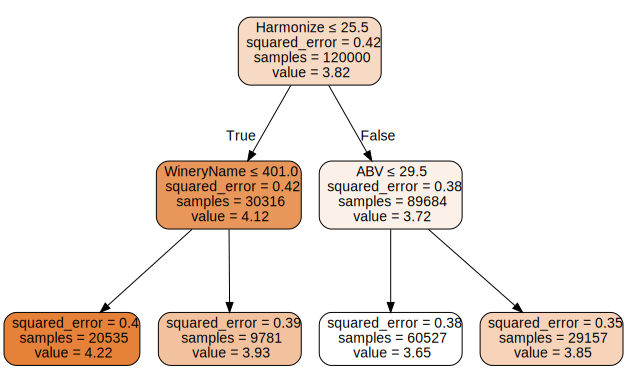

In [31]:
draw_tree(m, xs, size=25, leaves_parallel=True, precision=2)

In [37]:
samp_idx = np.random.permutation(len(y))[:500]

viz_rmodel = dtreeviz.model(model=m,
                            X_train=xs.iloc[samp_idx],
                            y_train=y.iloc[samp_idx],
                            feature_names=xs.columns,
                            target_name=dep_var)

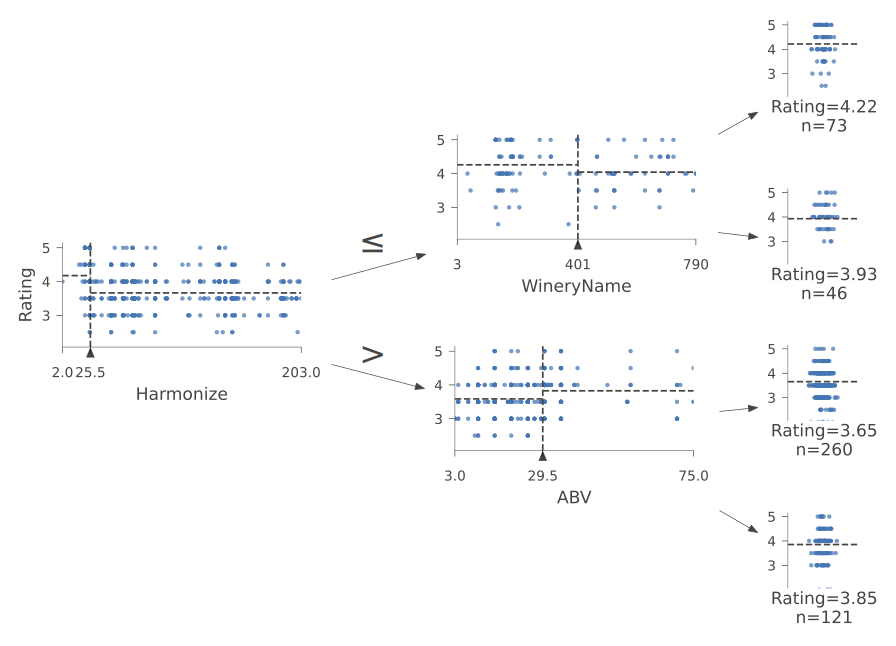

In [46]:
viz_rmodel.view(orientation="LR", fontname="DejaVu Sans", scale=2.3, label_fontsize=10)

In [47]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [48]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
m_rmse(m, xs, y)

0.0

In [49]:
m_rmse(m, valid_xs, valid_y)

0.719392

In [50]:
m.get_n_leaves(), len(xs)

(78083, 120000)

In [65]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.490729, 0.529253)

In [66]:
m.get_n_leaves()

3703

In [67]:
def rf(xs, y, n_estimators=50, max_samples=120000,
  max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
          max_samples=max_samples, max_features=max_features,
          min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
m = rf(xs, y);

In [62]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.443884, 0.528233)

In [60]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.444377, 0.528622)

In [58]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.445204, 0.529456)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [70]:
r_mse(preds.mean(0), valid_y)

0.52967

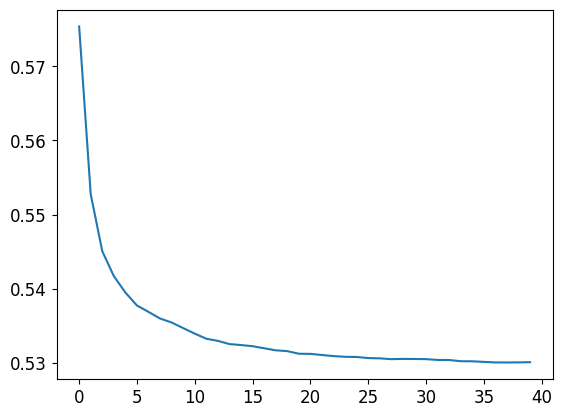

In [71]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [72]:
r_mse(m.oob_prediction_, y)

0.533274